## **Imports, Installations & Prerequisites**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
#to release all the GPU memory that can be freed
torch.cuda.empty_cache()

In [4]:
!pip -qq install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00


In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
DATA_PATH = "/content/drive/MyDrive/CSE579_NLP/Assignment_2/Data"

In [7]:
train_csv_path = os.path.join(DATA_PATH,"small_snli_train.tsv")
validation_csv_path = os.path.join(DATA_PATH,"snli_dev.tsv")
test_csv_path = os.path.join(DATA_PATH,"snli_test.tsv")

In [8]:
train_df = pd.read_csv(train_csv_path,sep="\t")
train_df = train_df[["sentence1","sentence2","gold_label"]]
train_df

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
1,Children smiling and waving at camera,There are children present,entailment
2,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.,entailment
3,Two blond women are hugging one another.,There are women showing affection.,entailment
4,"A few people in a restaurant setting, one of t...",The diners are at a restaurant.,entailment
...,...,...,...
19995,"A man helps a runner who has fallen, up from t...",A women assisted a runner who had fallen to th...,contradiction
19996,A man trying hard to finish a race,A man is sitting down.,contradiction
19997,A weary man is finishing a race.,A man is beginning to start a race.,contradiction
19998,"A child standing on a rug, wearing black sungl...",A child is sitting on a rug pointing.,contradiction


In [9]:
train_df.isna().sum() #code for checking any null values in data

sentence1     0
sentence2     0
gold_label    0
dtype: int64

In [10]:

#code for getting label wise counts into a python dictionary
labels_dict = dict(train_df["gold_label"].value_counts())
labels_dict

{'contradiction': 7500, 'neutral': 7000, 'entailment': 5500}

[Text(0, 0, '7500'), Text(0, 0, '7000'), Text(0, 0, '5500')]

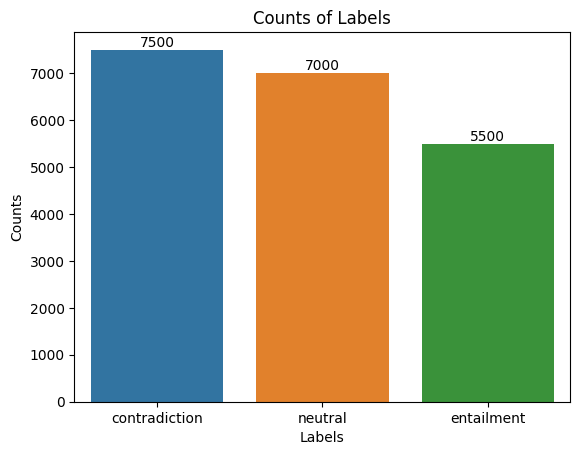

In [11]:
#code for plotting the bar plot using seaborn library with xlabel, ylabel and the values on bars.
ax = sns.barplot(x = list(labels_dict.keys()),y = list(labels_dict.values()))
ax.set(xlabel = "Labels",ylabel="Counts",title = "Counts of Labels")
ax.bar_label(ax.containers[0])

In [12]:
# Encoding the given categorical labels into numerical labels.
train_df['gold_label'] = train_df['gold_label'].replace(['contradiction','neutral','entailment'],[0,1,2])

In [13]:
#Given 2 sentences i.e., premise and hypothesis to be given as input, here the motive is to merge into a single sentence using some extra meaningful content
train_df["test_sentence"] = "Given Premise: "+train_df["sentence1"]+" we should determine the label for hypothesis: "+train_df["sentence2"]

In [14]:
#sample sentence after merging
train_df["test_sentence"].head()[0]

'Given Premise: A person on a horse jumps over a broken down airplane. we should determine the label for hypothesis: A person is outdoors, on a horse.'

In [15]:
#list of sentences to be tokenized and labels to be converted into tensors.
sentence1 = train_df["sentence1"].to_list()
sentence2 = train_df["sentence2"].to_list()
test_sentence = train_df["test_sentence"].to_list()
labels = train_df["gold_label"].to_list()

## **Tokenization**

In [16]:
from transformers import RobertaTokenizer
import torch

In [17]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

In [18]:
#printing the original sentence, tokenized sentence along with the token ids
print('Original sentence before tokenization : ', sentence1[0])
print('Tokenized sentence : ', tokenizer.tokenize(sentence1[0]))
print('Token IDs of tokenized sentence: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence1[0])))

Original sentence before tokenization :  A person on a horse jumps over a broken down airplane.
Tokenized sentence :  ['A', 'Ġperson', 'Ġon', 'Ġa', 'Ġhorse', 'Ġjumps', 'Ġover', 'Ġa', 'Ġbroken', 'Ġdown', 'Ġairplane', '.']
Token IDs of tokenized sentence:  [250, 621, 15, 10, 5253, 13855, 81, 10, 3187, 159, 16847, 4]


In [19]:
#code to iterate through all sentences and find the sentence with maximum length
max_len = 0
for sent in test_sentence:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length of all the sentences: ', max_len)

Max sentence length of all the sentences:  105


In [20]:
# tokenize all the sentences with truncation and padding to max_length, create tensors of attention masks and input_ids.
input_ids = []
attention_masks = []
for sent in test_sentence:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 105,
                        truncation = True,
                        padding = "max_length",
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids)
attention_masks = torch.cat(attention_masks)
labels = torch.tensor(labels)

print('Original sentence : ', test_sentence[0])
print('Token IDs:', input_ids[0])
print('Token IDs:', len(input_ids[0]))
print("Attention Masks of sentence: ",attention_masks[0])

Original sentence :  Given Premise: A person on a horse jumps over a broken down airplane. we should determine the label for hypothesis: A person is outdoors, on a horse.
Token IDs: tensor([    0, 18377, 22769,  1496,    35,    83,   621,    15,    10,  5253,
        13855,    81,    10,  3187,   159, 16847,     4,    52,   197,  3094,
            5,  6929,    13, 31098,    35,    83,   621,    16, 13384,     6,
           15,    10,  5253,     4,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,   

In [21]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(input_ids, attention_masks, labels)

# **Validation Set Preparation**

In [22]:
val_df = pd.read_csv(validation_csv_path,sep="\t")
val_df = val_df[["sentence1","sentence2","gold_label"]]
val_df["test_sentence"] = "Given Premise: "+val_df["sentence1"]+" we should determine the label for hypothesis: "+val_df["sentence2"]
val_df

,sentence1,sentence2,gold_label,test_sentence
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,neutral,Given Premise: Two women are embracing while h...
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,entailment,Given Premise: Two women are embracing while h...
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,contradiction,Given Premise: Two women are embracing while h...
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,entailment,Given Premise: Two young children in blue jers...
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,neutral,Given Premise: Two young children in blue jers...
...,...,...,...,...
9995,A small girl wearing a pink jacket is riding o...,The girl is sitting on a carved horse made of ...,-,Given Premise: A small girl wearing a pink jac...
9996,A small girl wearing a pink jacket is riding o...,The girl is moving at the speed of light.,contradiction,Given Premise: A small girl wearing a pink jac...
9997,A young girl with blue and pink ribbons in her...,People in a water fountain,entailment,Given Premise: A young girl with blue and pink...
9998,A young girl with blue and pink ribbons in her...,A young girl knits a sweater,contradiction,Given Premise: A young girl with blue and pink...


In [23]:
val_df["gold_label"].value_counts()

entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: gold_label, dtype: int64

In [24]:
#removing all other labels other than entailment, contradiction, neutral
val_df = val_df[val_df["gold_label"].isin(["entailment","contradiction","neutral"])]

In [25]:
#code for checking any null values in data
val_df.isna().sum()

sentence1        0
sentence2        0
gold_label       0
test_sentence    0
dtype: int64

In [26]:
val_df['gold_label'] = val_df['gold_label'].replace(['contradiction','neutral','entailment'],[0,1,2])


<ipython-input-26-811ea21449d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['gold_label'] = val_df['gold_label'].replace(['contradiction','neutral','entailment'],[0,1,2])


In [27]:
val_sentence1 = val_df["sentence1"].to_list()
val_sentence2 = val_df["sentence2"].to_list()
val_test_sentence = val_df["test_sentence"].to_list()
val_labels = val_df["gold_label"].to_list()

In [28]:
#code to iterate through all sentences and find the sentence with maximum length
max_len = 0
for sent in val_test_sentence:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length of all the sentences: ', max_len)

Max sentence length of all the sentences:  128


In [29]:
# tokenize all the sentences with truncation and padding to max_length, create tensors of attention masks and input_ids.
val_input_ids = []
val_attention_masks = []
for sent in val_test_sentence:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 128,
                        truncation = True,
                        padding = "max_length",
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    val_input_ids.append(encoded_dict['input_ids'])
    val_attention_masks.append(encoded_dict['attention_mask'])
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_labels)


In [30]:
from torch.utils.data import TensorDataset, random_split
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)


In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 64
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,

        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size,

        )

# **Training the model**

In [32]:
from transformers import RobertaForSequenceClassification,AdamW

In [33]:
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels = 3, #since our case is multi class classification(labels are one from Entatilment, Neutral, Contradiction)
    output_attentions = False,
    output_hidden_states = False,

)

# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [34]:
# from torch.optim import Adam
# optimizer = Adam(model.parameters(),
#                   lr = 2e-6,
#                   eps = 1e-8,
#                  amsgrad = True,
#                  maximize = True
#                   # weight_decay =  1e-6
#                 )


In [35]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
# from torch.optim import SGD
# optimizer = SGD(model.parameters(),lr = 2e-6,nesterov = True,momentum = 0.9)

In [37]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# scheduler = ReduceLROnPlateau(optimizer,patience = 2,verbose = True)

epochs = 4

In [38]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                          num_training_steps = total_steps)


In [39]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [40]:
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [41]:
import random
import numpy as np
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # scheduler.step(loss)
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:40.
  Batch    80  of    313.    Elapsed: 0:01:19.
  Batch   120  of    313.    Elapsed: 0:01:59.
  Batch   160  of    313.    Elapsed: 0:02:39.
  Batch   200  of    313.    Elapsed: 0:03:19.
  Batch   240  of    313.    Elapsed: 0:03:59.
  Batch   280  of    313.    Elapsed: 0:04:38.

  Average training loss: 0.61
  Training epcoh took: 0:05:11

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.41
  Validation took: 0:01:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:40.
  Batch    80  of    313.    Elapsed: 0:01:20.
  Batch   120  of    313.    Elapsed: 0:01:59.
  Batch   160  of    313.    Elapsed: 0:02:39.
  Batch   200  of    313.    Elapsed: 0:03:19.
  Batch   240  of    313.    Elapsed: 0:03:59.
  Batch   280  of    313.    Elapsed: 0:04:39.

  Average training loss: 0.39
  Training epcoh took: 0:05:11

Running Validation...
  Accuracy: 0.87
 

In [42]:
import pandas as pd
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.61,0.41,0.86,0:05:11,0:01:03
2,0.39,0.37,0.87,0:05:11,0:01:03
3,0.30,0.37,0.88,0:05:11,0:01:03
4,0.25,0.38,0.88,0:05:11,0:01:03


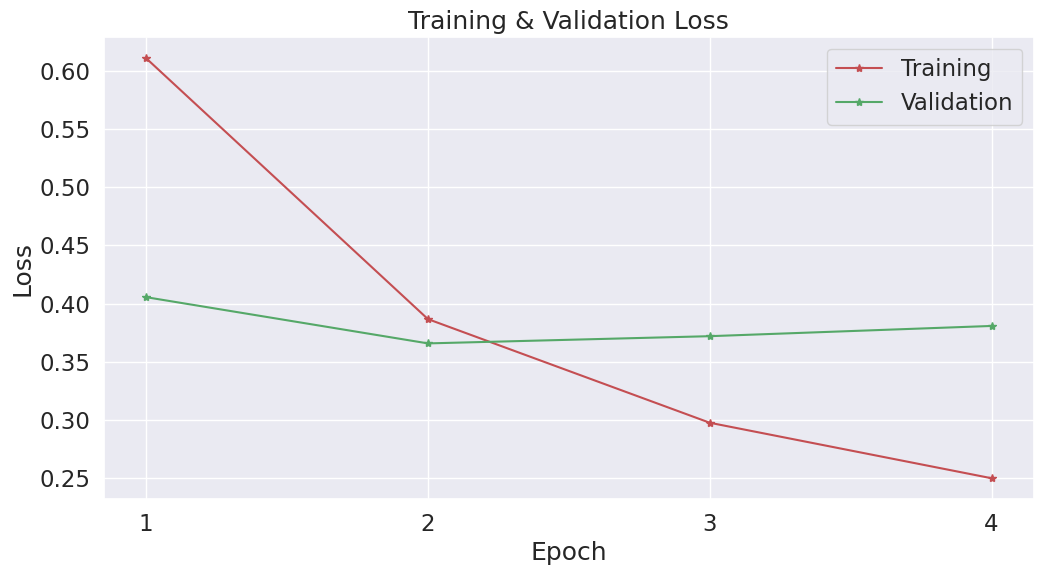

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'r-*', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-*', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# **Test Data Preparation**

In [44]:
test_df = pd.read_csv(test_csv_path,sep="\t")
test_df = test_df[["sentence1","sentence2","gold_label"]]
test_df["test_sentence"] = "Given Premise: "+test_df["sentence1"]+" we should determine the label for hypothesis: "+test_df["sentence2"]
test_df

,sentence1,sentence2,gold_label,test_sentence
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,Given Premise: This church choir sings to the ...
1,This church choir sings to the masses as they ...,The church is filled with song.,entailment,Given Premise: This church choir sings to the ...
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,Given Premise: This church choir sings to the ...
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,"Given Premise: A woman with a green headscarf,..."
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,"Given Premise: A woman with a green headscarf,..."
...,...,...,...,...
9995,Two women are observing something together.,Two women are standing with their eyes closed.,contradiction,Given Premise: Two women are observing somethi...
9996,Two women are observing something together.,Two girls are looking at something.,entailment,Given Premise: Two women are observing somethi...
9997,A man in a black leather jacket and a book in ...,A man is flying a kite.,contradiction,Given Premise: A man in a black leather jacket...
9998,A man in a black leather jacket and a book in ...,A man is speaking in a classroom.,entailment,Given Premise: A man in a black leather jacket...


In [45]:
test_df["gold_label"].value_counts()

entailment       3368
contradiction    3237
neutral          3219
-                 176
Name: gold_label, dtype: int64

In [46]:
test_df = test_df[test_df["gold_label"].isin(["entailment","contradiction","neutral"])]

In [47]:
test_df.isna().sum()

sentence1        0
sentence2        0
gold_label       0
test_sentence    0
dtype: int64

In [48]:
test_df['gold_label'] = test_df['gold_label'].replace(['contradiction','neutral','entailment'],[0,1,2])


<ipython-input-48-14d1af321edc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['gold_label'] = test_df['gold_label'].replace(['contradiction','neutral','entailment'],[0,1,2])


In [49]:
test_sentence1 = test_df["sentence1"].to_list()
test_sentence2 = test_df["sentence2"].to_list()
fin_test_sentence = test_df["test_sentence"].to_list()
test_labels = test_df["gold_label"].to_list()

In [50]:
max_len = 0
for sent in fin_test_sentence:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  89


In [51]:
test_input_ids = []
test_attention_masks = []
for sent in fin_test_sentence:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 89,
                        truncation = True,
                        padding = "max_length",
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)


In [52]:
from torch.utils.data import TensorDataset, random_split
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


In [53]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 64
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [64]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
model.eval()
predictions , true_labels = [], []
for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  pred_labels = np.argmax(logits, axis=1)
  label_ids = b_labels.to('cpu').numpy()
  predictions.extend(pred_labels.tolist())
  true_labels.extend(label_ids.tolist())

Predicting labels for 9,824 test sentences...


In [65]:
import json
from sklearn.metrics import classification_report

result_report= classification_report(true_labels, predictions, digits=3,output_dict = True)
print(json.dumps(result_report,indent=4))

{
    "0": {
        "precision": 0.8940961655508217,
        "recall": 0.9076305220883534,
        "f1-score": 0.900812509581481,
        "support": 3237
    },
    "1": {
        "precision": 0.8358392144829703,
        "recall": 0.8462255358807083,
        "f1-score": 0.8410003087372645,
        "support": 3219
    },
    "2": {
        "precision": 0.9082037206465385,
        "recall": 0.8842042755344418,
        "f1-score": 0.8960433278170604,
        "support": 3368
    },
    "accuracy": 0.8794788273615635,
    "macro avg": {
        "precision": 0.8793797002267768,
        "recall": 0.8793534445011678,
        "f1-score": 0.8792853820452686,
        "support": 9824
    },
    "weighted avg": {
        "precision": 0.8798438365682242,
        "recall": 0.8794788273615635,
        "f1-score": 0.8795789917984903,
        "support": 9824
    }
}


In [66]:
import json
with open("1229700331_results.json","w") as fp:
  json.dump(result_report,fp,indent=4)


# **Saving Model**

In [67]:

import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/CSE579_NLP/Assignment_2/Model'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/CSE579_NLP/Assignment_2/Model


('/content/drive/MyDrive/CSE579_NLP/Assignment_2/Model/tokenizer_config.json',
 '/content/drive/MyDrive/CSE579_NLP/Assignment_2/Model/special_tokens_map.json',
 '/content/drive/MyDrive/CSE579_NLP/Assignment_2/Model/vocab.json',
 '/content/drive/MyDrive/CSE579_NLP/Assignment_2/Model/merges.txt',
 '/content/drive/MyDrive/CSE579_NLP/Assignment_2/Model/added_tokens.json')